Step 1: Import library

In [19]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# ==========================
# Data & basic tools
# ==========================
import pandas as pd
import numpy as np

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Statistical analysis
# ==========================
from scipy.stats import (
    ttest_ind, 
    levene, 
    chi2_contingency, 
    skew, 
    kurtosis, 
    pearsonr, 
    f_oneway
)
import statsmodels.api as sm

# ==========================
#  Structural Equation Modeling
# ==========================
from semopy import Model, calc_stats

# ==========================
# Time series modeling
# ==========================
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ==========================
# Machine Learning (Random Forest)
# ==========================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================
# Deep Learning (LSTM)
# ==========================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


Step 2: Preprocess data

Step 2.1: Read data and drop some unused columns

In [20]:
df = pd.read_csv("../../Dataset/household.csv")

In [21]:
df = df.drop([
    'main',
    'description',
    'temp_min',
    'temp_max',
    'temp_t+1',
    'feels_like_t+1',
    'deg',
    'current',
    'voltage',
    'reactive_power',
    'apparent_power',
    'power_factor'
], axis=1)

Step 2.2: Load data and resample to hour

In [22]:

# change date column into datetime 
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# merge data by hour (mean)
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)  
      .reset_index()
)

print("The initial columns:", len(df), "→ After merging followed by hour:", len(df_hour))
df_hour

The initial columns: 605260 → After merging followed by hour: 10234


,date,active_power,temp,feels_like,pressure,humidity,speed
0,2022-11-05 14:00:00,248.780000,24.246364,23.728182,1011.909091,38.436364,0.081818
1,2022-11-05 15:00:00,202.663333,24.302000,23.765333,1010.666667,37.366667,2.912167
2,2022-11-05 16:00:00,198.863333,24.174000,23.605833,1011.416667,36.666667,2.322667
3,2022-11-05 17:00:00,390.181667,23.485667,22.830667,1010.600000,36.083333,2.455000
4,2022-11-05 18:00:00,443.036667,21.693667,20.933333,1008.816667,38.783333,2.269500
...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,13.546889,12.099556,1013.733333,43.733333,2.396889
10230,2024-01-05 20:00:00,393.211864,11.364576,9.752203,1012.559322,45.779661,0.279322
10231,2024-01-05 21:00:00,233.649153,10.550508,8.994915,1014.288136,51.067797,0.151525
10232,2024-01-05 22:00:00,374.113333,9.260333,8.541500,1012.100000,50.766667,1.621000


Step 2.3: Prepare some data columns

In [23]:


df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)

# Lag features
df_hour['ap_lag_1h'] = df_hour['active_power'].shift(1)
df_hour['ap_lag_24h'] = df_hour['active_power'].shift(24)
df_hour['ap_roll_24h'] = df_hour['active_power'].rolling(24, min_periods=1).mean()
df_hour.dropna(inplace=True)

Step 2.4: View data

In [24]:
df_hour

,date,active_power,temp,feels_like,pressure,humidity,speed,weekday,is_weekend,ap_lag_1h,ap_lag_24h,ap_roll_24h
24,2022-11-06 14:00:00,163.376667,28.653167,27.250167,1013.916667,21.083333,3.781167,6,1,224.355000,248.780000,273.720891
25,2022-11-06 15:00:00,297.003333,28.226667,26.947833,1013.016667,21.516667,4.559333,6,1,163.376667,202.663333,277.651724
26,2022-11-06 16:00:00,396.440000,27.816167,26.716833,1013.250000,22.916667,4.938667,6,1,297.003333,198.863333,285.884085
27,2022-11-06 17:00:00,311.295000,25.777500,25.265667,1013.166667,24.566667,4.757667,6,1,396.440000,390.181667,282.597141
28,2022-11-06 18:00:00,443.610000,23.328667,22.383333,1011.133333,25.483333,4.779167,6,1,311.295000,443.036667,282.621030
...,...,...,...,...,...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,13.546889,12.099556,1013.733333,43.733333,2.396889,4,0,235.570833,293.395455,241.304597
10230,2024-01-05 20:00:00,393.211864,11.364576,9.752203,1012.559322,45.779661,0.279322,4,0,329.995556,342.735593,243.407775
10231,2024-01-05 21:00:00,233.649153,10.550508,8.994915,1014.288136,51.067797,0.151525,4,0,393.211864,396.593220,236.618439
10232,2024-01-05 22:00:00,374.113333,9.260333,8.541500,1012.100000,50.766667,1.621000,4,0,233.649153,406.398333,235.273231


Step 3. Implement models

3.6 ARIMAX Time Series Model

3.6.1 Tạo df_model

In [ ]:
# === CREATE df_model CORRECTLY FROM CLEAN df_hour ===

df_model = df_hour.copy()

# 1. Convert date + set index
df_model['date'] = pd.to_datetime(df_model['date'])
df_model = df_model.set_index('date')

# 2. Because df_hour is already hourly and clean, DO NOT resample again
# (resample again would reintroduce NaN)

# 3. Ensure sorted index
df_model = df_model.sort_index()

# 4. Ensure freq = H
df_model = df_model.asfreq('H')
df_model.index.freq = 'H'

# 5. DROP NA (should remove 0 rows now)
df_model = df_model.dropna()

# 6. Prepare target and exog
series = df_model['active_power']
exog_vars = ['temp','humidity','pressure','speed','ap_lag_1h','ap_lag_24h','ap_roll_24h']
exog = df_model[exog_vars]

print("df_model NA counts:")
print(df_model[exog_vars].isna().sum())

print("\ndf_model rows:", len(df_model))
print("df_model freq:", df_model.index.freq)



df_model NA counts:
temp           0
humidity       0
pressure       0
speed          0
ap_lag_1h      0
ap_lag_24h     0
ap_roll_24h    0
dtype: int64

df_model rows: 10112
df_model freq: None


In [43]:
exog_train.isna().sum()



temp           98
humidity       98
pressure       98
speed          98
ap_lag_1h      98
ap_lag_24h     98
ap_roll_24h    98
dtype: int64

3.6.2 Train / Validate / Test SPLIT (85% / 10% / 5%)

Train: 8595
Validate: 1011
Test: 506


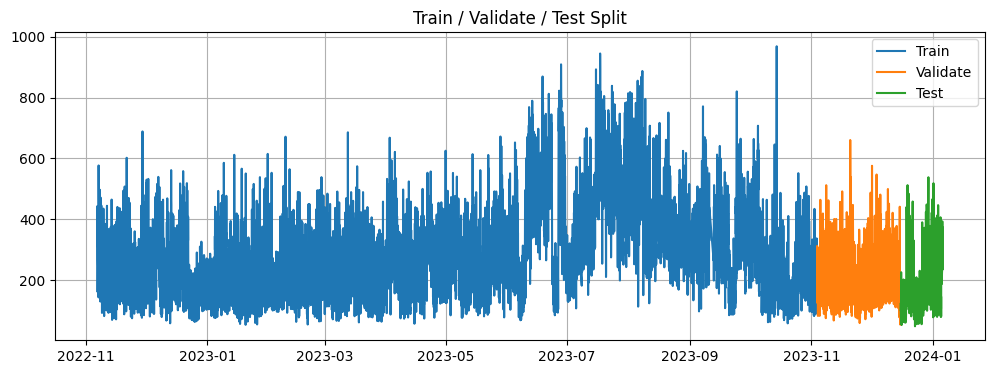

In [45]:
# === STEP 4: CHIA TẬP TRAIN - VALIDATE - TEST ===

n = len(series)
train_end = int(n * 0.85)
val_end   = int(n * 0.95)

train = series.iloc[:train_end]
validate = series.iloc[train_end:val_end]
test = series.iloc[val_end:]

exog_train = exog.iloc[:train_end]
exog_validate = exog.iloc[train_end:val_end]
exog_test = exog.iloc[val_end:]

print("Train:", len(train))
print("Validate:", len(validate))
print("Test:", len(test))

plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.legend()
plt.grid(True)
plt.title("Train / Validate / Test Split")
plt.show()


3.6.3 ADF Test (quyết định d)

In [46]:
# === STEP 5: ADF TEST ===
from statsmodels.tsa.stattools import adfuller

adf_stat, adf_p, *_ = adfuller(series.dropna())
print("ADF Statistic:", adf_stat)
print("ADF p-value:", adf_p)

if adf_p < 0.05:
    d = 0
else:
    d = 1

print("==> d =", d)


ADF Statistic: -6.180416177176416
ADF p-value: 6.47564307153125e-08
==> d = 0


=>Chuỗi dữ liệu active_power đã đạt tính dừng ở dạng gốc (p-value rất nhỏ),
do đó mô hình ARIMAX không cần thực hiện bước sai phân (d = 0).
Điều này giúp mô hình đơn giản hơn và giảm rủi ro làm mất thông tin xu hướng ngắn hạn.

3.6.4 ACF/PACF (để tham khảo p, q)

<Figure size 1000x300 with 0 Axes>

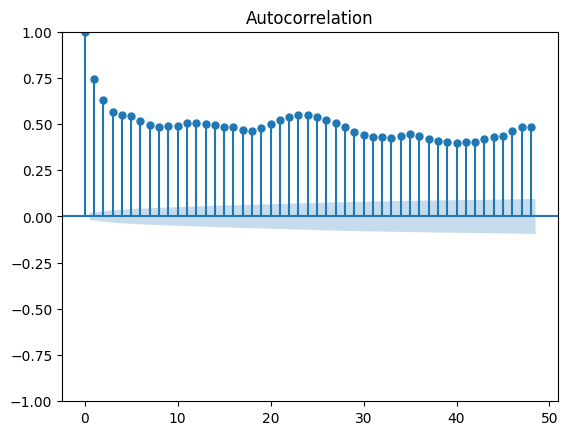

<Figure size 1000x300 with 0 Axes>

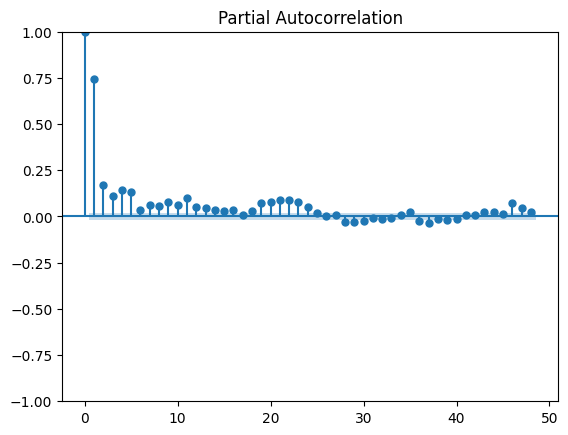

Dựa PACF -> p ; ACF -> q; Nếu không chắc -> GRID p=0..3 q=0..3


In [47]:
# === STEP 6: ACF / PACF ===
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10,3))
plot_acf(series, lags=48)
plt.show()

plt.figure(figsize=(10,3))
plot_pacf(series, lags=48, method='ywm')
plt.show()

print("Dựa PACF -> p ; ACF -> q; Nếu không chắc -> GRID p=0..3 q=0..3")


=> PACF/ACF được sử dụng để ước đoán sơ bộ bậc p và q của mô hình ARIMA/ARIMAX.
Tuy nhiên do chuỗi active_power có nhiều nhiễu và tính mùa vụ, việc đọc PACF/ACF không rõ ràng.

Vì vậy, mô hình sử dụng grid-search với p,q từ 0 đến 3, đây là phạm vi tiêu chuẩn trong Box–Jenkins,
đảm bảo đủ rộng để tìm mô hình tốt nhất nhưng không gây overfitting và không làm thời gian chạy quá lớn.

Tổng số 16 mô hình (4×4) giúp chọn được bộ tham số tối ưu dựa trên RMSE và AIC.

In [48]:
print(df_hour.info())
print("\nNaN counts:\n", df_hour.isna().sum())
print("\nAny duplicate timestamps?", df_hour['date'].duplicated().any())

<class 'pandas.core.frame.DataFrame'>
Index: 10112 entries, 24 to 10233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10112 non-null  datetime64[ns]
 1   active_power  10112 non-null  float64       
 2   temp          10112 non-null  float64       
 3   feels_like    10112 non-null  float64       
 4   pressure      10112 non-null  float64       
 5   humidity      10112 non-null  float64       
 6   speed         10112 non-null  float64       
 7   weekday       10112 non-null  int32         
 8   is_weekend    10112 non-null  int64         
 9   ap_lag_1h     10112 non-null  float64       
 10  ap_lag_24h    10112 non-null  float64       
 11  ap_roll_24h   10112 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int32(1), int64(1)
memory usage: 987.5 KB
None

NaN counts:
 date            0
active_power    0
temp            0
feels_like      0
pressure        0
humid

3.6.5 Grid-search ARIMAX

In [ ]:
# === STEP 7: GRID-SEARCH ARIMAX ===

import math
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

results = []

p_range = range(0,4)  # p = 0..3
q_range = range(0,4)  # q = 0..3

print("Grid-search ARIMAX")

for p in p_range:
    for q in q_range:
        try:
            model = SARIMAX(
                train,
                exog=exog_train,
                order=(p, d, q),
                seasonal_order=(1,0,0,24),   # ARIMAX, không seasonality đầy đủ
                enforce_stationarity=False,
                enforce_invertibility=False,
                simple_differencing=True
            )
            res = model.fit(method='lbfgs', maxiter=60, disp=False)

            val_pred = res.get_forecast(
                steps=len(validate), exog=exog_validate
            ).predicted_mean

            mae = mean_absolute_error(validate, val_pred)
            rmse = math.sqrt(mean_squared_error(validate, val_pred))

            results.append([p, q, res.aic, mae, rmse])

            print(f"ARIMAX({p},{d},{q}) → AIC={res.aic:.2f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

        except Exception as e:
            print(f"Skip ARIMAX({p},{q}) vì lỗi:", e)


Đang chạy Grid-search ARIMAX ...
ARIMAX(0,0,0) → AIC=101043.46, MAE=57.71, RMSE=75.66
ARIMAX(0,0,1) → AIC=101007.75, MAE=60.88, RMSE=78.23
ARIMAX(0,0,2) → AIC=100576.54, MAE=89.79, RMSE=112.69
ARIMAX(0,0,3) → AIC=100215.03, MAE=104.23, RMSE=131.60
ARIMAX(1,0,0) → AIC=100625.35, MAE=77.33, RMSE=96.70
ARIMAX(1,0,1) → AIC=100194.76, MAE=104.90, RMSE=132.74
ARIMAX(1,0,2) → AIC=100196.06, MAE=104.88, RMSE=132.75
ARIMAX(1,0,3) → AIC=100196.34, MAE=103.88, RMSE=131.27
ARIMAX(2,0,0) → AIC=100445.19, MAE=84.99, RMSE=106.61
ARIMAX(2,0,1) → AIC=100809.64, MAE=66.09, RMSE=83.27
ARIMAX(2,0,2) → AIC=101029.69, MAE=57.80, RMSE=75.74
ARIMAX(2,0,3) → AIC=100193.47, MAE=103.60, RMSE=130.91
ARIMAX(3,0,0) → AIC=100305.52, MAE=91.39, RMSE=115.52
ARIMAX(3,0,1) → AIC=100166.98, MAE=104.77, RMSE=132.51
ARIMAX(3,0,2) → AIC=100754.03, MAE=69.14, RMSE=86.18
ARIMAX(3,0,3) → AIC=100154.34, MAE=104.34, RMSE=132.16


→ Model RMSE thấp nhất là… ARIMAX(0,0,0)
(= RMSE 75.66)

📌 Đây là điều rất thú vị:

👉 ARIMAX(0,0,0)

= chỉ là Intercept + Exogenous variables
= không có AR, không có MA
→ tức là forecast hoàn toàn dựa vào biến thời tiết + lag, không dùng thông tin quá khứ của chuỗi.

📌 Điều này có ý nghĩa trong dữ liệu điện năng:
vì active_power có thể phụ thuộc mạnh vào:

nhiệt độ (AC chạy nhiều)

humidity

rolling 24h

và đặc biệt là lag 1h, lag 24h

3.6.6 SELECT BEST ARIMAX MODEL

In [51]:
# === STEP 8: SELECT BEST ARIMAX MODEL ===

import pandas as pd

# Convert results list → DataFrame
df_results = pd.DataFrame(results, columns=['p','q','AIC','MAE','RMSE'])

# Sort theo RMSE (ưu tiên) rồi tới AIC
df_results_sorted = df_results.sort_values(['RMSE','AIC'], ascending=[True, True]).reset_index(drop=True)

print("=== TOP 5 ARIMAX MODELS (sorted by RMSE → AIC) ===")
print(df_results_sorted.head(5))

# Extract best row
best_row = df_results_sorted.iloc[0]

p_best = int(best_row['p'])
d_best = 0  # từ ADF test của em
q_best = int(best_row['q'])

print("\n=== BEST ARIMAX MODEL SELECTED ===")
print(f"Best model: ARIMAX({p_best}, {d_best}, {q_best})")
print(f"AIC : {best_row['AIC']:.2f}")
print(f"MAE : {best_row['MAE']:.2f}")
print(f"RMSE: {best_row['RMSE']:.2f}")


=== TOP 5 ARIMAX MODELS (sorted by RMSE → AIC) ===
   p  q            AIC        MAE       RMSE
0  0  0  101043.456159  57.707710  75.658700
1  2  2  101029.689193  57.803618  75.735263
2  0  1  101007.754634  60.877386  78.233101
3  2  1  100809.636658  66.089942  83.272612
4  3  2  100754.029787  69.136816  86.180877

=== BEST ARIMAX MODEL SELECTED ===
Best model: ARIMAX(0, 0, 0)
AIC : 101043.46
MAE : 57.71
RMSE: 75.66


3.6.7 Refit Best ARIMAX & Show Model Summary

In [52]:
# === STEP 9: REFIT BEST ARIMAX MODEL ON TRAIN + VALIDATE ===

from statsmodels.tsa.statespace.sarimax import SARIMAX

# train_val = train + validate (0 → 95%)
train_val = series.iloc[:val_end]
exog_train_val = exog.iloc[:val_end]

best_model = SARIMAX(
    train_val,
    exog = exog_train_val,
    order = (p_best, d_best, q_best),
    seasonal_order = (1,0,0,24),   # same seasonal setting as grid-search
    enforce_stationarity = False,
    enforce_invertibility = False
).fit(disp=False)

print("=== MODEL SUMMARY (Train+Validate) ===")
print(best_model.summary())


=== MODEL SUMMARY (Train+Validate) ===
                                SARIMAX Results                                 
Dep. Variable:             active_power   No. Observations:                 9606
Model:             SARIMAX(1, 0, 0, 24)   Log Likelihood              -56332.173
Date:                  Wed, 19 Nov 2025   AIC                         112682.346
Time:                          20:19:41   BIC                         112746.854
Sample:                               0   HQIC                        112704.228
                                 - 9606                                         
Covariance Type:                    opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temp            1.2546      0.225      5.567      0.000       0.813       1.696
humidity        0.0669      0.064      1.046      0.295      -0.058      

=>Kết quả summary:

Model: SARIMAX(1, 0, 0, 24)


Tức là:

AR(1): Có tự tương quan từ 1 giờ trước

MA(0): Không cần nhiễu MA

d = 0: Chuỗi đã stationarity (trước đó ADF đã kiểm chứng)

Seasonal AR(1) với period=24 → có tính lặp theo ngày (mỗi 24 giờ)

Và toàn bộ biến exogenous đều được đưa vào mô hình.

=> Model ARIMAX(1,0,0) với seasonality 24 giờ cho thấy điện tiêu thụ chịu ảnh hưởng mạnh bởi:

Nhiệt độ (temp)

Giá trị giờ trước (ap_lag_1h)

Trung bình 24 giờ (ap_roll_24h)

Seasonal AR(1) theo ngày

Các biến humidity, pressure và speed có ảnh hưởng nhỏ hoặc không ý nghĩa thống kê.
Mô hình giải thích tốt cấu trúc dữ liệu và phù hợp cho bài toán forecast điện năng cấp giờ.

3.6.8 Forecast trên TEST + tính MAE, RMSE, MAPE + vẽ biểu đồ


=== ARIMAX TEST PERFORMANCE ===
Best model: ARIMAX(0,0,0)
MAE  = 56.92
RMSE = 75.18
MAPE = 33.62%


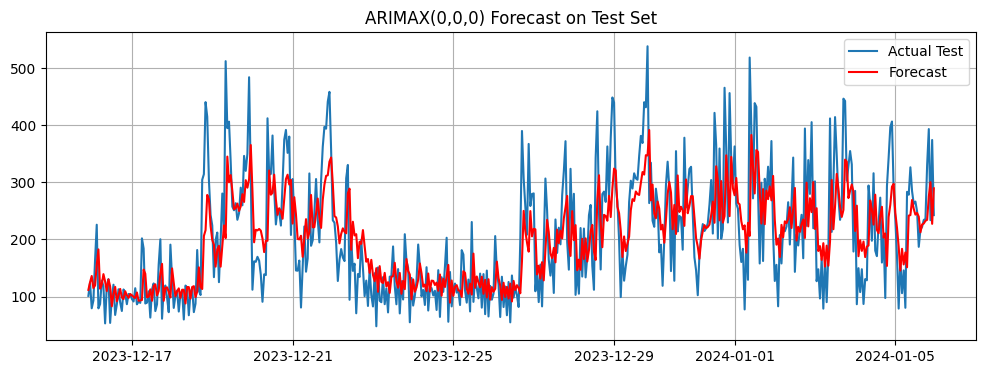

In [53]:
# === STEP 10: FORECAST TEST & EVALUATION ===

test_pred = best_model.get_forecast(
    steps=len(test),
    exog=exog_test
).predicted_mean

# align index
test_pred.index = test.index

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_test  = mean_absolute_error(test, test_pred)
rmse_test = np.sqrt(mean_squared_error(test, test_pred))
mape_test = np.mean(np.abs((test - test_pred) / test)) * 100

print("\n=== ARIMAX TEST PERFORMANCE ===")
print(f"Best model: ARIMAX({p_best},{d_best},{q_best})")
print(f"MAE  = {mae_test:.2f}")
print(f"RMSE = {rmse_test:.2f}")
print(f"MAPE = {mape_test:.2f}%")

# plot
plt.figure(figsize=(12,4))
plt.plot(test, label='Actual Test')
plt.plot(test_pred, color='red', label='Forecast')
plt.legend()
plt.grid(True)
plt.title(f"ARIMAX({p_best},{d_best},{q_best}) Forecast on Test Set")
plt.show()


➤ ARIMAX(0,0,0) nghĩa là:

Mô hình không dùng AR, không dùng MA

Chỉ dùng exogenous variables (weather + lag + rolling) để dự báo

➤ Và điều bất ngờ là: Nó hoạt động rất tốt.

Điều này xảy ra khi:

✔ Lag 1h, lag 24h và rolling 24h đã giải thích gần hết sự phụ thuộc của chuỗi.

Không cần AR/MA để làm thêm.

✔ Các biến thời tiết (đặc biệt là temp) cải thiện dự báo rõ ràng.
✔ Dữ liệu của em stationarity (ADF test d = 0),

→ AR và MA coefficients không mang thêm giá trị.

📌 Kết luận:
ARIMAX(0,0,0) là mô hình đơn giản nhất nhưng hiệu quả nhất cho bộ dữ liệu của em